In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function, absolute_import
import matplotlib.pyplot as plt
import numpy as np

import pydrake
from pydrake.all import (
    AutoDiffXd, Expression, Variable,
    MathematicalProgram, SolverType, SolutionResult,
    DirectCollocationConstraint, AddDirectCollocationConstraint,
    PiecewisePolynomial,
    DiagramBuilder, SignalLogger, Simulator, VectorSystem,
)

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

from traj.dircol import (
    make_real_dircol_mp,
)

from nn_system.NNSystemHelper import (
    make_NN_constraint,
)

from nn_system.networks import *

In [114]:
##############################
#       SETTINGS
##############################
# kNetConstructor = FC
# kNetConstructor = MLPSMALL
kNetConstructor = MLP
kNumTimesteps = 21
prog, tree = make_real_dircol_mp(expmt="acrobot", seed=1776)

# Make vars for mathematical program to know about neural network
num_params = sum(tensor.nelement() for tensor in kNetConstructor().parameters())
num_inputs = 1
num_states = 4
print("total params: ", sum((num_inputs, num_states, num_params)))
T = prog.NewContinuousVariables(num_params, 'T')

# Apply this NN constraint to all timesteps!
for t in range(kNumTimesteps):
    # Only one output value, so let's have lb and ub of just size one!
    constraint = make_NN_constraint(kNetConstructor, num_inputs, num_states, num_params)
    lb         = -np.array([.1])
    ub         = np.array([.1])
    var_list   = np.hstack((prog.input(t), prog.state(t), T))
    prog.AddConstraint(constraint, lb, ub, var_list)
    pass


total params:  438


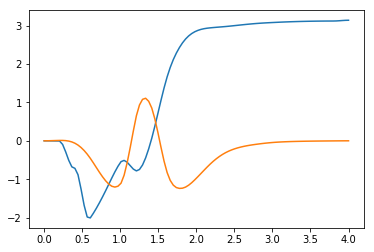

In [4]:
############################################################
# Run this cell to run the code!
############################################################

prog.SetSolverOption(SolverType.kSnopt, 'Print file', "/tmp/snopt.out")
ret = prog.Solve()

x_trajectory = prog.ReconstructStateTrajectory()
breaks = np.linspace(x_trajectory.start_time(),x_trajectory.end_time(),100)
x_knots = np.hstack([x_trajectory.value(t) for t in breaks])

plt.plot(breaks, x_knots[0,:], breaks, x_knots[1,:])

## Test make_NN_constraint

In [3]:
# kNetConstructor = FC
kNetConstructor = MLPSMALL
num_params = sum(tensor.nelement() for tensor in kNetConstructor().parameters())
num_inputs = 1
num_states = 4
total_params = sum((num_inputs, num_states, num_params))
print("total params: ", total_params)

constraint = make_NN_constraint(kNetConstructor, num_inputs, num_states, num_params)

total params:  134


In [ ]:
import copy
np.random.seed(1776)
# Make total_param number of AutoDiffXd's, with (seeded) random values.
# Set derivatives array to length total_param with only index i set for ith AutoDiff.
# values = np.random.randn(total_params)
values = np.ones(total_params)
def one_hot(i, n_params):
    ret = np.zeros(n_params)
    ret[i] = 1
    return ret

uxT = np.array([AutoDiffXd(values[i], one_hot(i, total_params)) for i in range(total_params)])
out = copy.deepcopy(constraint(uxT)[0])
out_value = out.value()
out_derivatives = out.derivatives()

# f     : function(np.array of AutoDiffXd's) -> array of size one of AutoDiffXd
# x     : np.array of AutoDiffXd at which to calculate finite_difference
# idx   : Index of AutoDiffXd in x to perturb
# delta : magnitude of perturbation of AutoDiffXd at index idx of x
def finite_difference(f, x, idx, delta):
    x_hi = copy.deepcopy(x)
    x_hi[idx] += delta
    x_lo = copy.deepcopy(x)
    x_lo[idx] -= delta
    return ( f(x_hi)[0].value() - f(x_lo)[0].value() ) / (2*delta)

for idx in range(total_params):    
    # Do finite difference calculation and compare against gradient
    grad = finite_difference(constraint, uxT, idx, 0.1)
    ref_grad = out_derivatives[idx]
    print(idx, grad, ref_grad)add_regularization

## Trying out multiple trajectories with Russ's example code and Pendulum env

In [3]:
# from traj.dircol import (
#     make_multiple_dircol_trajectories,
#     make_real_dircol_mp,
# )
from traj.vis import (
    add_multiple_trajectories_visualization_callback,
    add_visualization_callback,
    create_nn_policy_system,
    plot_multiple_dircol_trajectories,
    simulate_and_log_policy_system,
    visualize_trajectory,
)
# from nn_system.NNSystemHelper import (
#     add_nn_params,
# )
from multiple_traj_opt import MultipleTrajOpt



#### Construct the inital MathematicalProgram
num_trajectories = 1
num_samples      = 15
initial_conditions = (
    None,
#     "1",
#     "2",
#     "3",
)[0]
mto = MultipleTrajOpt("pendulum",
                      num_trajectories, 
                      num_samples,
                      initial_conditions=initial_conditions)

#### Add a neural network!
# kNetConstructor = lambda: FC(2)
kNetConstructor = lambda: FCBIG(2)
# kNetConstructor = lambda: MLPSMALL(2)
# kNetConstructor = lambda: MLP(2)
reg_type = "No"
# reg_type = "L1"
# reg_type = "L2"
mto.add_nn_params(kNetConstructor,
                  initialize_params = True, 
                  reg_type          = reg_type,
                  enable_constraint = True)

prog = mto.prog
h = mto.h
u = mto.u
x = mto.x
T = mto.T

In [4]:
# Introduce a scaling factor in (0, 1] that can be used to shrink the initial
# conditions regions used for policy rollouts, so we can check an area SMALLER
# than that which was used for dircol calculations!
# scaling = 0.5
# mto.add_multiple_trajectories_visualization_callback(
#     "pendulum")#,
#     initial_conditions=lambda ti: np.array(initial_conditions2(ti))*scaling )

In [5]:
result = mto.Solve()
print(result)

SolutionResult.kSolutionFound


In [6]:
ti = 0    
mto.print_pi_divergence(ti)

u_val-Pi(x_val)= diff
(-4.25)-(-4.35)=  0.10
(-5.30)-(-5.20)= -0.10
(-2.39)-(-2.49)=  0.10
(-1.04)-(-1.11)=  0.07
(-0.45)-(-0.54)=  0.09
(-0.13)-(-0.03)= -0.10
( 0.15)-( 0.05)=  0.10
( 0.38)-( 0.48)= -0.10
( 0.63)-( 0.53)=  0.10
( 1.10)-( 1.20)= -0.10
( 1.60)-( 1.55)=  0.06
( 1.36)-( 1.34)=  0.02
( 0.49)-( 0.57)= -0.09
(-0.46)-(-0.37)= -0.09
(-0.62)-(-0.55)= -0.07


In [7]:
ti = 0
ani = mto.render_policy(ti)
from IPython.display import HTML
HTML(ani.to_html5_video())

/home/rverkuil/integration/integration/local/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/rverkuil/integration/integration/local/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


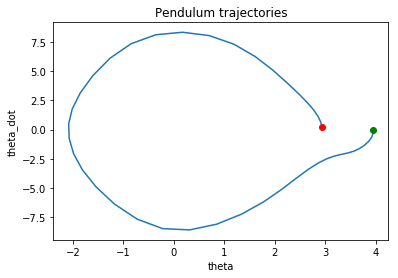

In [8]:
mto.plot_all_trajectories()

### Visualize the found trajectories

NameError: global name 'PendulumVisualizer' is not defined

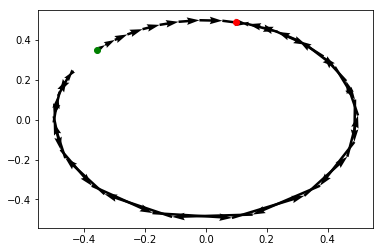

In [9]:
###### plt.figure()
# for ti in range(num_trajectories):
# for ti in [0]:

ti = 0
mto.plot_single_trajectory(ti)

ani2 = mto.render_single_trajectory(ti)
HTML(ani2.to_html5_video())